In [1]:
import socrata_api_wrapper
from socrata_api_wrapper import SocrataAPI
import psql_helper
from psql_helper import PsqlConnection
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
import psycopg2
%matplotlib inline

In [2]:
reload(socrata_api_wrapper)
reload(psql_helper)

<module 'psql_helper' from 'psql_helper.pyc'>

In [3]:
token = 'Opp5gz1KaGplrPjbqnSsWkqHB'

In [4]:
api = SocrataAPI(token)
psql = PsqlConnection(db='traffic_accident', user='minghuang')

Connection Open


# Get 911 response data

In [5]:
r = api.request('https://data.seattle.gov/resource/pu5n-trf4.json')
headers = r.get_headers()
r.set_primary_id('cad_cdw_id')

In [5]:
r.download_csv(file_name='911calls.csv')

Download Complete


In [6]:
psql.drop_table('raw_911_response')
psql.create_table(headers, 'raw_911_response')
psql.insert_csv('raw_911_response', '/Users/minghuang/Documents/temp/911calls.csv')

Table raw_911_response dropped.
Table raw_911_response created in traffic_accident
CSV inserted into raw_911_response.


#Get road weather data

In [7]:
r = api.request('https://data.seattle.gov/resource/egc4-d24i.json')
headers = r.get_headers()
r.set_primary_id('recordid')

In [23]:
r.download_csv(file_name='roadweather.csv')

Download Complete


In [8]:
psql.drop_table('raw_road_weather')
psql.create_table(headers, 'raw_road_weather')
psql.insert_csv('raw_road_weather', '/Users/minghuang/Documents/temp/roadweather.csv')

Table raw_road_weather dropped.
Table raw_road_weather created in traffic_accident
CSV inserted into raw_road_weather.


In [9]:
psql.end_connection()

Connection Closed


#EDA

In [10]:
conn = psycopg2.connect(dbname='traffic_accident', user='minghuang', host='localhost')
query = "select * from raw_911_response where event_clearance_description = 'MOTOR VEHICLE COLLISION';"
df = pd.read_sql_query(query, con=conn)

In [11]:
df.head()

,cad_cdw_id,at_scene_time,cad_event_number,census_tract,district_sector,event_clearance_code,event_clearance_date,event_clearance_description,event_clearance_group,event_clearance_subgroup,general_offense_number,hundred_block_location,incident_location,initial_type_description,initial_type_group,initial_type_subgroup,latitude,longitude,zone_beat
0,1531626,2015-08-27T12:13:00.000,15000299420,6600.1025,D,430,2015-08-27T14:28:00.000,MOTOR VEHICLE COLLISION,MOTOR VEHICLE COLLISION INVESTIGATION,TRAFFIC RELATED CALLS,2015299420,16XX BLOCK OF EASTLAKE AV E,"{u'type': u'Point', u'coordinates': [-122.3254...","MOTOR VEHICLE COLLISION, REPORT ONLY - NON INJ...",TRAFFIC RELATED CALLS,MOTOR VEHICLE COLLISION INVESTIGATION,47.634362773,-122.325401505,D3
1,1531622,2015-08-27T13:28:00.000,15000299512,7300.3011,D,430,2015-08-27T14:29:00.000,MOTOR VEHICLE COLLISION,MOTOR VEHICLE COLLISION INVESTIGATION,TRAFFIC RELATED CALLS,2015299512,THOMAS ST / BOREN AV N,"{u'type': u'Point', u'coordinates': [-122.3358...","TRU- MOTOR VEHICLE COLLISION, HIT AND RUN AFTE...",TRAFFIC RELATED CALLS,MOTOR VEHICLE COLLISION INVESTIGATION,47.620862708,-122.335859476,D3
2,1531595,,15000299502,4302.1007,U,430,2015-08-27T13:51:00.000,MOTOR VEHICLE COLLISION,MOTOR VEHICLE COLLISION INVESTIGATION,TRAFFIC RELATED CALLS,2015299502,22 AV NE / NE 47 ST,"{u'type': u'Point', u'coordinates': [-122.3044...","TRU- MOTOR VEHICLE COLLISION, HIT AND RUN AFTE...",TRAFFIC RELATED CALLS,MOTOR VEHICLE COLLISION INVESTIGATION,47.663071648,-122.304470135,U1
3,1531590,,15000299537,8200.2006,E,430,2015-08-27T13:55:00.000,MOTOR VEHICLE COLLISION,MOTOR VEHICLE COLLISION INVESTIGATION,TRAFFIC RELATED CALLS,2015299537,8 AV / MADISON ST,"{u'type': u'Point', u'coordinates': [-122.3284...","TRU- MOTOR VEHICLE COLLISION, HIT AND RUN AFTE...",TRAFFIC RELATED CALLS,MOTOR VEHICLE COLLISION INVESTIGATION,47.607943692,-122.328471925,E3
4,1531588,,15000299563,11101.4004,R,430,2015-08-27T13:56:00.000,MOTOR VEHICLE COLLISION,MOTOR VEHICLE COLLISION INVESTIGATION,TRAFFIC RELATED CALLS,2015299563,M L KING JR WY S / S GRAHAM ST,"{u'type': u'Point', u'coordinates': [-122.2854...",MOTOR VEHICLE COLLISION WITH INJURIES - PRIORI...,TRAFFIC RELATED CALLS,MOTOR VEHICLE COLLISION INVESTIGATION,47.546057749,-122.285452803,R3


In [12]:
lgt = df.longitude.astype(float).values
lat = df.latitude.astype(float).values

In [13]:
print min(lgt), max(lgt)
print min(lat), max(lat)

-122.419091527 -122.237546385
47.499911475 47.733948981


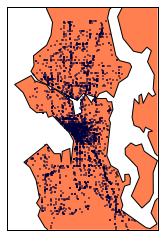

In [14]:
m = Basemap(projection='merc',# lat_0 = 57, lon_0 = -135,
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=-122.45, llcrnrlat=47.5,
    urcrnrlon=-122.2, urcrnrlat=47.75)

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color = 'coral')
m.drawmapboundary()

x, y = m(lgt, lat)
m.plot(x, y, 'bo', markersize=1)
 
plt.show()